# Introduction

Censuses are collections of data that represent a whole population and provide the investigators with a better understanding of the demographic, as well as to paint a statistical portrait of the population according to specific characteristics. The census we will use is on US citizens in 1994. The data was used to predict if an individual’s income would be over or under $50k/year. We want  to see if visual indicators can be a good indicator of income.  This dataset provides a range of categorical and numerical variables that can identify an individual. 


# Preliminary Exploratory Data Analysis

In this section we provide code that downloads, cleans/wrangles, splits, summarizes, and plots our data. 

In [19]:
# Install and load the necessary libraries
library(readr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

# Define the URL for the Census Income dataset
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Define column names
column_names <- c("age", "workclass", "fnlwgt", "education", "education_num", 
                  "marital_status", "occupation", "relationship", "race", 
                  "sex", "capital_gain", "capital_loss", "hours_per_week", 
                  "native_country", "income")

# Read the Census Income dataset into a dataframe
census_data <- read.csv(url, header = FALSE, col.names = column_names)

# Display the first few rows of the dataframe
head(census_data)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>
1,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
3,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
4,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
5,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
6,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [20]:
# Create test and train splits
census_split = initial_split(census_data, prop = 0.75, strata = income)
census_training = training(census_split)
census_testing = testing(census_split)

In [22]:
# Create a table summarizing the number of observations for each class in income, sex, race
summary_table <- census_training |>
  group_by(income, sex, race) |>
  summarize(count = n())

# Display the summary table, print them for better readability
print("Summary Table:")
print(summary_table)

# Produce means for age, education_num, hours_per_week (vars we will likely use)
means_table <- census_training |>
    group_by(income, sex, race) |>
    summarize(
        mean_age = mean(age),
        mean_education_num = mean(education_num),
        mean_hours_per_week = mean(hours_per_week)
      )

print("Means Table:")
print(means_table)

# Find the number of rows with missing values
missing_rows_training <- census_training %>%
  summarise_all(~sum(is.na(.)))

# Display the number of rows with missing values
print("Number of Rows with Missing Values:")
print(sum(missing_rows_training))

`summarise()` has grouped output by 'income', 'sex'. You can override using the
`.groups` argument.


[1] "Summary Table:"
# A tibble: 20 × 4
# Groups:   income, sex [4]
   income   sex       race                  count
   <chr>    <chr>     <chr>                 <int>
 1 " <=50K" " Female" " Amer-Indian-Eskimo"    83
 2 " <=50K" " Female" " Asian-Pac-Islander"   235
 3 " <=50K" " Female" " Black"               1090
 4 " <=50K" " Female" " Other"                 78
 5 " <=50K" " Female" " White"               5741
 6 " <=50K" " Male"   " Amer-Indian-Eskimo"   119
 7 " <=50K" " Male"   " Asian-Pac-Islander"   326
 8 " <=50K" " Male"   " Black"                972
 9 " <=50K" " Male"   " Other"                102
10 " <=50K" " Male"   " White"               9794
11 " >50K"  " Female" " Amer-Indian-Eskimo"     7
12 " >50K"  " Female" " Asian-Pac-Islander"    33
13 " >50K"  " Female" " Black"                 69
14 " >50K"  " Female" " Other"                  4
15 " >50K"  " Female" " White"                757
16 " >50K"  " Male"   " Amer-Indian-Eskimo"    19
17 " >50K"  " Male"   " Asian-Pa

`summarise()` has grouped output by 'income', 'sex'. You can override using the
`.groups` argument.


[1] "Means Table:"
# A tibble: 20 × 6
# Groups:   income, sex [4]
   income   sex       race       mean_age mean_education_num mean_hours_per_week
   <chr>    <chr>     <chr>         <dbl>              <dbl>               <dbl>
 1 " <=50K" " Female" " Amer-In…     37.0               9.25                36.2
 2 " <=50K" " Female" " Asian-P…     34.2              10.4                 36.5
 3 " <=50K" " Female" " Black"       37.7               9.42                36.5
 4 " <=50K" " Female" " Other"       32.0               8.69                35.5
 5 " <=50K" " Female" " White"       35.9               9.90                35.7
 6 " <=50K" " Male"   " Amer-In…     36.3               8.97                42.3
 7 " <=50K" " Male"   " Asian-P…     37.2              10.6                 39.9
 8 " <=50K" " Male"   " Black"       35.9               9.06                38.9
 9 " <=50K" " Male"   " Other"       34.3               8.48                41.5
10 " <=50K" " Male"   " White"       37.4  

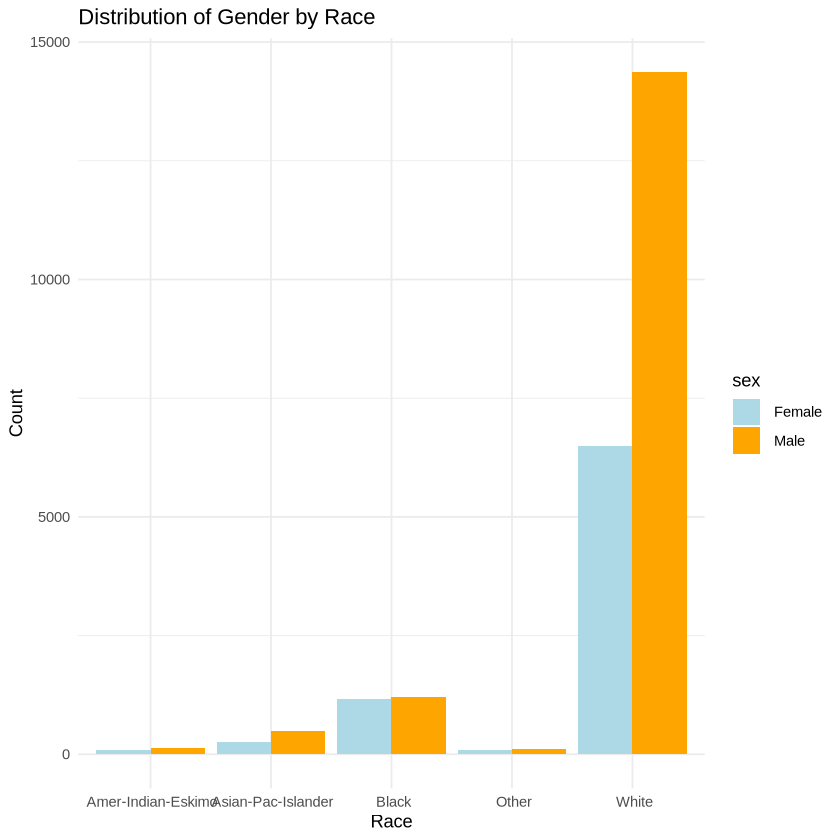

In [23]:
# Create a bar plot to identify distribution of race by gender in our dataset
gener_by_race_plot <- ggplot(census_training, aes(x = race, fill = sex)) +
  geom_bar(position = "dodge", stat = "count") +
  labs(title = "Distribution of Gender by Race",
       x = "Race",
       y = "Count") +
  scale_fill_manual(values = c("lightblue", "orange")) +
  theme_minimal()

gener_by_race_plot

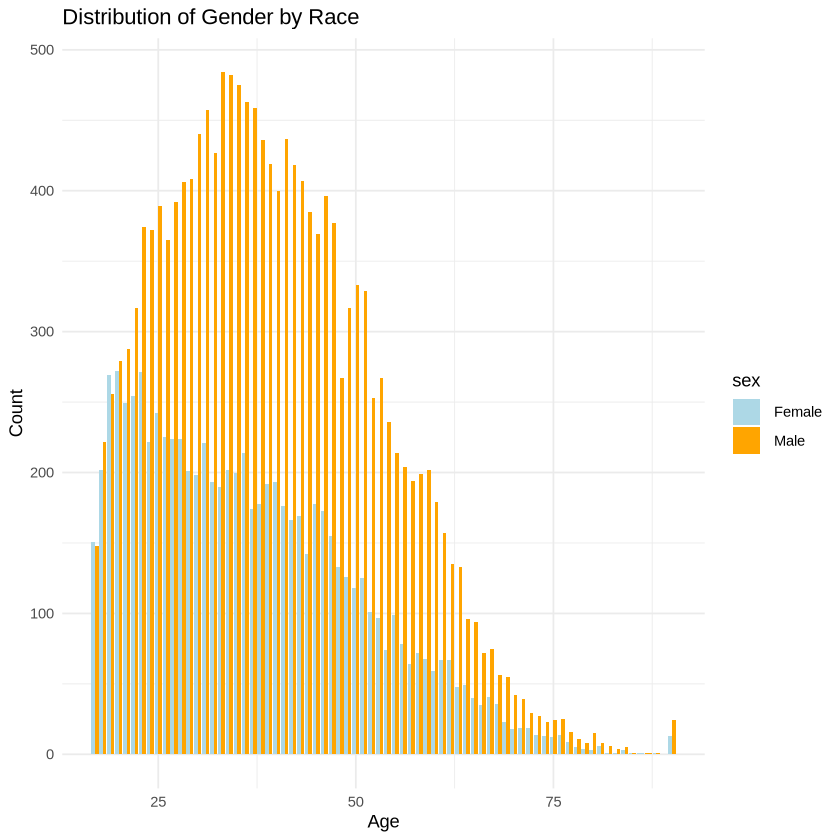

In [24]:
# Create a bar plot to identify distribution of ager by gender in our dataset
gener_by_age_plot <- ggplot(census_training, aes(x = age, fill = sex)) +
  geom_bar(position = "dodge", stat = "count") +
  labs(title = "Distribution of Gender by Race",
       x = "Age",
       y = "Count") +
  scale_fill_manual(values = c("lightblue", "orange")) +
  theme_minimal()

gener_by_age_plot

# Methods

For our data analysis, we will be specifically looking at proving whether or not race and gender are good indicators of income. To do this we will conduct ablation studies where we vary the inclusion of one or more variables in hopes of showing an improved or worse-off classifier when each respective variable is included or not. Specifically, we are interested in race and gender but we will include other variables like age, education, occupation, relationship status and hours worked per week to establish a base model to conduct the ablation of visual characteristics (race, gender) with. To visualize our results we will plot accuracy versus test configuration across many variants we achieve during the ablation study. We will also plot income versus accuracy where gender and race are identified through a fill. 

# Expected Outcomes and Significance

We expect to find that there is a correlation between visual indicators and income, with certain variables being more important than others. This information could be used in workplace training workshops discussing topics relating to equity and diversity. It could also aid in the development of hiring policies relating to fairness and employee rights protection. It is important to note this data is 30 years old. The next step would be to apply our methodology to more recent data to measure the differences between eras and whether any significant changes can be seen.